In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import math

from keras.constraints import NonNeg
from keras import Input, Model
from keras.layers import Embedding
import keras.backend as K

from arms.bernoulli import BernoulliArm
%matplotlib inline

Using TensorFlow backend.


In [2]:
def loss(y_true,y_pred):
        return - K.log(y_pred)*y_true

class DeepBandit():
    def __init__(self, num_bandits):
        input_action = Input((1,))
        responsible_weight = Embedding(num_bandits, 
                               1, 
                               name='weights', 
                               embeddings_initializer='ones',
                               embeddings_constraint=NonNeg())(input_action)

        self.model = Model(input_action, responsible_weight)
        self.model.compile(optimizer='adam', loss=loss)
        self.e = 0.1
        self.num_bandits = num_bandits
        return
    
    def initialize(self, num_bandits):
        return
    
    def select_arm(self):
        if np.random.rand(1) < self.e:
            action = np.random.randint(self.num_bandits)
        else:
            action = self.model.get_layer('weights').get_weights()[0].argmax()
        return action

  
    def update(self, chosen_arm, reward):
        if reward == 0:
            reward = -1
        self.model.fit(np.array([chosen_arm]), np.array(reward)[np.newaxis],verbose=0)

In [3]:
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm = np.argmax(means)
print("Best arm is " + str(best_arm))

Best arm is 2


In [4]:
%%time
from testing_framework.tests import *

algo = DeepBandit(n_arms)
results = test_algorithm(algo, arms, 10, 250)
dataframe = pd.DataFrame(np.array(results).T,columns=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 4.5 s, sys: 633 ms, total: 5.14 s
Wall time: 3.67 s


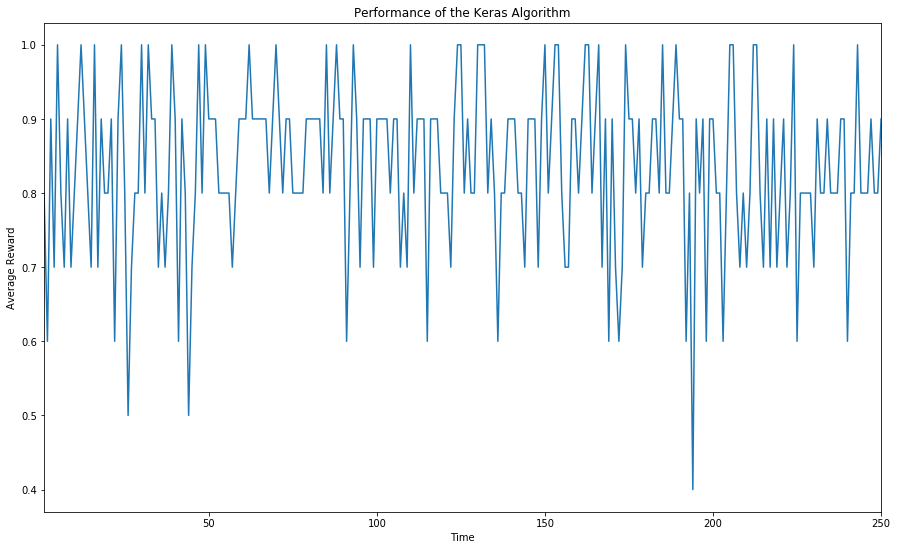

In [5]:
ax = dataframe.groupby("T").mean()['Reward'].plot(figsize=(15,9))
ax.set_title("Performance of the Keras Algorithm")
ax.set_ylabel('Average Reward');
ax.set_xlabel('Time');

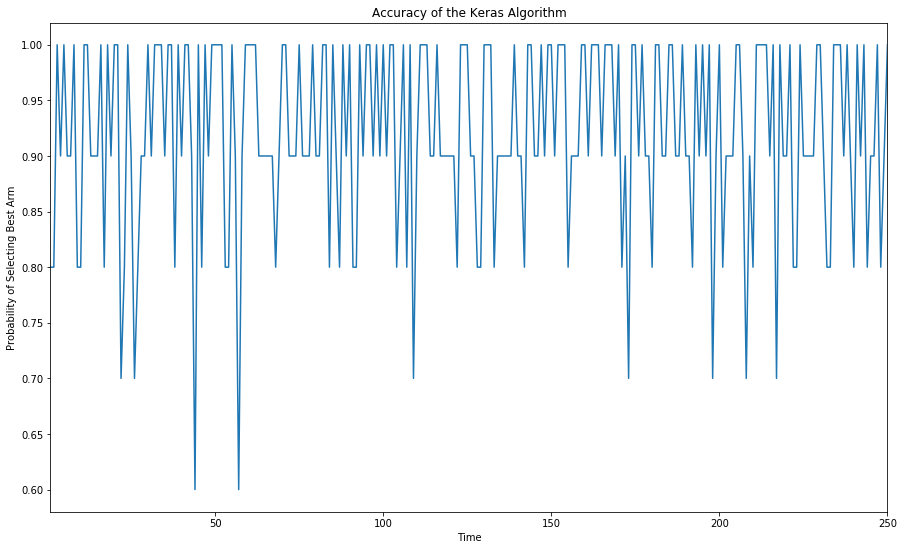

In [6]:
df_grouped = dataframe.groupby(["T","ChosenArm"]).count()/dataframe.Sim.max()
df_grouped = df_grouped.reset_index()
ax = df_grouped[df_grouped['ChosenArm'] == float(best_arm)].set_index('T')['Reward'].plot(figsize=(15,9))
ax.set_title("Accuracy of the Keras Algorithm")
ax.set_ylabel('Probability of Selecting Best Arm');
ax.set_xlabel('Time');

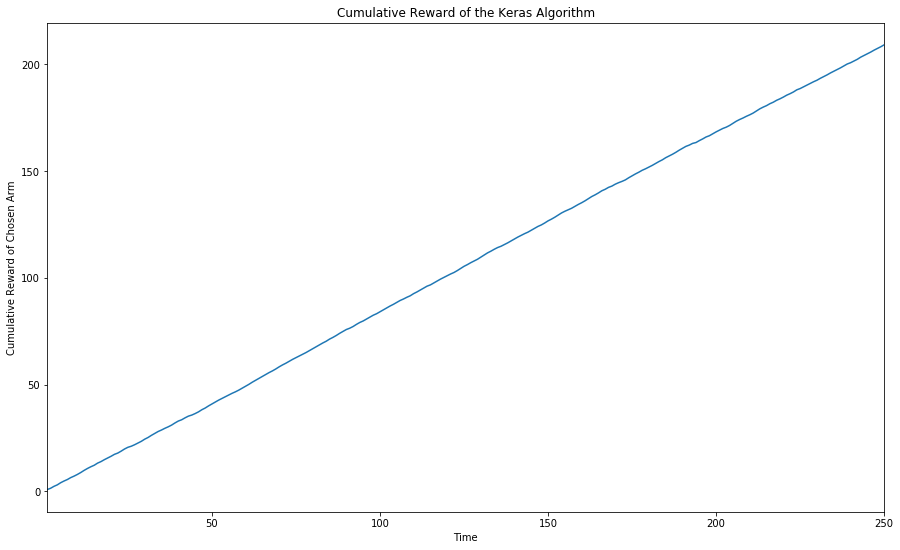

In [7]:
ax = dataframe.groupby("T").mean()['CumulativeReward'].plot(figsize=(15,9))
ax.set_title("Cumulative Reward of the Keras Algorithm")
ax.set_ylabel('Cumulative Reward of Chosen Arm');
ax.set_xlabel('Time');

In [ ]:
dataframe.to_csv("Keras_results.csv",index=None)